In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce

In [2]:
# Initializing simulation parameters
iterations = 0
epoch_size = 500
num_nodes = 10
seed = 42

### Processing Delivery Report dataset

In [28]:
fileName = ('data/prophet_delivery_report.xlsx')
df = pd.read_excel(fileName)
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (3086, 10)


,time,ID,size,hopcount,deliveryTime,fromHost,toHost,remainingTtl,isResponse,path
0,1566.1,M21,9952,1,0.1,p0,p6,1499,N,p0->p6
1,1669.6,M4,8257,1,1377.6,p7,p1,1477,N,p7->p1
2,2237.0,M29,8083,1,37.0,p5,p0,1499,N,p5->p0
3,2237.1,M20,8205,1,734.1,p0,p5,1487,N,p0->p5
4,2237.2,M8,9587,1,1599.2,p0,p7,1473,N,p0->p5


In [29]:
def unpackTuple(tup):
    return (reduce(operator.add, tup))


def preProcessing(df):
    # Assigning a time Index to each entry
    df['epoch_index'] = df.apply(lambda row: int(row['time'] / epoch_size),
                                 axis=1)

    df.drop([
        'time', 'hopcount', 'deliveryTime', 'remainingTtl', 'isResponse',
        'size'
    ],
            axis=1,
            inplace=True)  #dropping unnecessary columns

    # Formatting to parseable form
    df["fromHost"] = df["fromHost"].str.replace("p", "")
    df["toHost"] = df["toHost"].str.replace("p", "")
    df["path"] = df["path"].str.replace("p", "")
    df["ID"] = df["ID"].str.replace("M", "")

    # Splitting the path entries
    df["path"] = df["path"].str.split("->").apply(list)

    # Grouping all entries of a message in an epoch
    # to generate all the nodes visited during that epoch
    df = df.groupby(['ID', 'epoch_index', 'fromHost',
                     'toHost'])['path'].apply(list).reset_index()
    # Unpacking path
    df['path'] = df.apply(lambda row: set(unpackTuple(row['path'])), axis=1)

    df['fromHost'] = df['fromHost'].astype(int)
    df['toHost'] = df['toHost'].astype(int)
    df['ID'] = df['ID'].astype(int)

    return df

In [30]:
df = preProcessing(df)
df

,ID,epoch_index,fromHost,toHost,path
0,1,4,6,1,"{7, 6, 5, 0}"
1,1,5,6,1,"{7, 1, 6, 0}"
2,1,11,6,1,"{6, 3}"
3,1,22,6,1,"{8, 6, 3}"
4,1,36,6,1,"{8, 4, 6, 3}"
...,...,...,...,...,...
2762,99,19,6,7,"{6, 0}"
2763,99,27,6,7,"{1, 6, 0}"
2764,99,29,6,7,"{7, 1, 6, 0}"
2765,99,54,6,7,"{1, 6, 5, 0}"


### Processing Node Locations dataset

In [31]:
fileName2 = ('data/prophet_NodeLocs.xlsx')
df2 = pd.read_excel(fileName2)
print('Dataset size: ', df2.shape)
df2.head()

Dataset size:  (22400, 4)


,time,node,x,y
0,25,p0,359.2952,593.5965
1,25,p1,595.1697,864.0757
2,25,p2,150.4684,323.1847
3,25,p3,246.6003,679.0803
4,25,p4,99.0202,383.6092


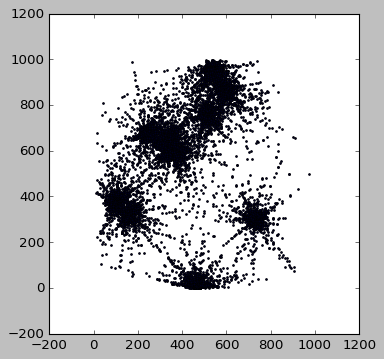

In [32]:
plt.style.use("classic")
plt.figure(figsize=(5, 5))
plt.scatter(df2['x'], df2['y'], s=2, cmap='rainbow')
plt.show()

### Determining optimal value of K in K Means Clustering

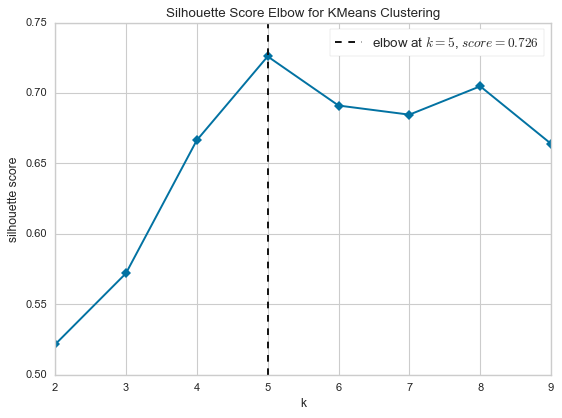

In [ ]:
# Import the KElbowVisualizer method
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model,
                              k=(2, num_nodes + 1),
                              metric='silhouette',
                              timings=False)

# Fit the node locations data and visualize
visualizer.fit(data)
visualizer.poof()

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', n_init=num_nodes)
data = df2[['x', 'y']]
kmeans.fit(data)

df2["node"] = df2["node"].str.replace("p", "")
df2['node'] = df2['node'].astype(int)
df2['cluster_label'] = kmeans.fit_predict(df2[df2.columns[2:4]])

df2

,time,node,x,y,cluster_label
0,25,0,359.2952,593.5965,0
1,25,1,595.1697,864.0757,2
2,25,2,150.4684,323.1847,3
3,25,3,246.6003,679.0803,0
4,25,4,99.0202,383.6092,3
...,...,...,...,...,...
22395,56000,5,511.8530,720.8290,2
22396,56000,6,343.5899,643.3298,0
22397,56000,7,531.3970,956.0542,2
22398,56000,8,744.8229,294.0880,4


In [34]:
temp = [[i, round(df2[df2['node'] == i]['cluster_label'].mean())]
        for i in range(num_nodes)]
df3 = pd.DataFrame(temp, columns=['node', 'region'])
df3

,node,region
0,0,0
1,1,2
2,2,3
3,3,0
4,4,3
5,5,2
6,6,0
7,7,2
8,8,4
9,9,1


#### Plotting the node clusters

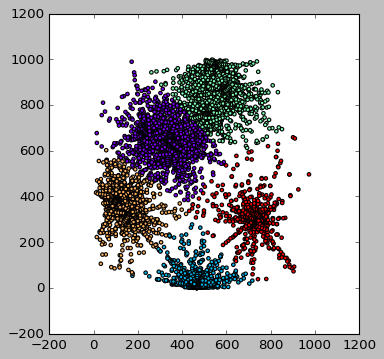

In [35]:
plt.figure(figsize=(5, 5))
plt.scatter(data['x'], data['y'], c=kmeans.labels_, cmap='rainbow', s=10)
plt.show()

In [36]:
# Merging the two databases to create region code features
df = pd.merge(df, df3, left_on="fromHost", right_on="node")
df = pd.merge(df, df3, left_on="toHost", right_on="node")
df = df.drop(['node_x', 'node_y'], axis=1)
df['deliveryStatus'] = df.apply(lambda row: row['toHost'] in row['path'],
                                axis=1)
df

,ID,epoch_index,fromHost,toHost,path,region_x,region_y,deliveryStatus
0,1,4,6,1,"{7, 6, 5, 0}",0,2,False
1,1,5,6,1,"{7, 1, 6, 0}",0,2,False
2,1,11,6,1,"{6, 3}",0,2,False
3,1,22,6,1,"{8, 6, 3}",0,2,False
4,1,36,6,1,"{8, 4, 6, 3}",0,2,False
...,...,...,...,...,...,...,...,...
2762,77,22,2,6,"{2, 8, 0, 3}",3,0,False
2763,77,23,2,6,"{2, 4}",3,0,False
2764,77,65,2,6,"{2, 0, 5}",3,0,False
2765,77,90,2,6,"{2, 0, 9}",3,0,False


In [37]:
# Generating the labels (d0-d9)
for x in range(num_nodes):
    label = 'd' + str(x)
    df[label] = df.apply(lambda row: str(x) in row['path'], axis=1)

df.drop(['ID'], axis=1, inplace=True)
df.drop(['path'], axis=1, inplace=True)
df

,epoch_index,fromHost,toHost,region_x,region_y,deliveryStatus,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9
0,4,6,1,0,2,False,True,False,False,False,False,True,True,True,False,False
1,5,6,1,0,2,False,True,True,False,False,False,False,True,True,False,False
2,11,6,1,0,2,False,False,False,False,True,False,False,True,False,False,False
3,22,6,1,0,2,False,False,False,False,True,False,False,True,False,True,False
4,36,6,1,0,2,False,False,False,False,True,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,22,2,6,3,0,False,True,False,True,True,False,False,False,False,True,False
2763,23,2,6,3,0,False,False,False,True,False,True,False,False,False,False,False
2764,65,2,6,3,0,False,True,False,True,False,False,True,False,False,False,False
2765,90,2,6,3,0,False,True,False,True,False,False,False,False,False,False,True


In [38]:
X = df[df.columns[:6]][:]
y = df[df.columns[6:]]
print(X.shape)
print(y.shape)

(2767, 6)
(2767, 10)


Dividing into test and train splits

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2213, 6) (2213, 10)
(554, 6) (554, 10)


In [41]:
# Scaling the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [42]:
pip install scikit-multilearn

### Importing the required libraries


In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import zero_one_loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from statistics import mean
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Tuning the Hyperparameters for XGBoost

In [44]:
y_train2 = y_train['d0']
y_test2 = y_test['d0']

In [45]:
# Defining search space for parameters
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.quniform("max_depth", 40, 70, 2),
    'gamma': hp.uniform('gamma', 0, 2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 0.97),
    'min_child_weight': hp.quniform('min_child_weight', 0, 1, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': 180,
    'seed': 42
}

In [46]:
def objective(space):
    clf = xgb.XGBClassifier(learning_rate=space['learning_rate'],
                            n_estimators=space['n_estimators'],
                            max_depth=int(space['max_depth']),
                            gamma=space['gamma'],
                            min_child_weight=int(space['min_child_weight']),
                            colsample_bytree=space['colsample_bytree'],
                            subsample=space['subsample'],
                            n_jobs=-1)

    evaluation = [(X_train, y_train2), (X_test, y_test2)]

    clf.fit(X_train,
            y=y_train2,
            eval_set=evaluation,
            eval_metric="error",
            early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test2, pred > 0.5)
    print("Score:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [47]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=200,
                        trials=trials)

Score:
0.8916967509025271
Score:
0.9296028880866426
Score:
0.907942238267148
Score:
0.9169675090252708
Score:
0.8646209386281588
Score:
0.9097472924187726
Score:
0.8826714801444043
Score:
0.8826714801444043
Score:
0.9259927797833934
Score:
0.924187725631769
Score:
0.907942238267148
Score:
0.9007220216606499
Score:
0.9296028880866426
Score:
0.8700361010830325
Score:
0.8465703971119134
Score:
0.9187725631768953
Score:
0.9205776173285198
Score:
0.9296028880866426
Score:
0.9151624548736462
Score:
0.927797833935018
Score:
0.9458483754512635
Score:
0.9169675090252708
Score:
0.9404332129963899
Score:
0.9223826714801444
Score:
0.8844765342960289
Score:
0.9386281588447654
Score:
0.907942238267148
Score:
0.9259927797833934
Score:
0.9314079422382672
Score:
0.9169675090252708
Score:
0.9368231046931408
Score:
0.924187725631769
Score:
0.9133574007220217
Score:
0.9296028880866426
Score:
0.8971119133574007
Score:
0.8971119133574007
Score:
0.9296028880866426
Score:
0.9169675090252708
Score:
0.906137184

In [48]:
print("The best XGBoost hyperparameters are : ", "\n")
print(best_hyperparams)

The best XGBoost hyperparameters are :  

{'colsample_bytree': 0.8450524103173055, 'gamma': 0.4284728966385598, 'learning_rate': 0.9720876660425267, 'max_depth': 68.0, 'min_child_weight': 0.0, 'reg_lambda': 0.7310636113121688, 'subsample': 0.7092073987000459}


### Tuning the Hyperparameters for AdaBoost

In [50]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose some parameter combinations to try
parameters = {
    'n_estimators': np.arange(100, 200, 2),
    'learning_rate': [0.1, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00001]
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)
clf = AdaBoostClassifier()

# Run the grid search
grid_search = GridSearchCV(estimator=clf,
                           param_grid=parameters,
                            cv=5,
                           verbose=1,
                           scoring=acc_scorer,
                           n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train['d0'])

print('Best Parameters for our classsifier')
print('=' * 50)
print(grid_search.best_params_)
print('=' * 50)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:  6.4min finished


Best Parameters for our classsifier
{'learning_rate': 0.1, 'n_estimators': 198}


### Optimal Hyperparameters after tuning

XGBoost - Epidemic<br>
{'colsample_bytree': 0.8051446237389833,<br>
'gamma': 0.2991055746915884,<br>
'learning_rate': 0.10093931755220432,<br>
'max_depth': 42.0,<br>
'min_child_weight': 0.0,<br>
'reg_lambda': 0.11676119223227349,<br>
'subsample': 0.7969490785671262}
<br><br>
Accuracy -> 0.8863920099875156

XGBoost - PRoPHET<br>
{'colsample_bytree': 0.8450524103173055,<br>
 'gamma': 0.4284728966385598,<br>
  'learning_rate': 0.9720876660425267,<br>
   'max_depth': 68.0,<br>
    'min_child_weight': 0.0,<br>
     'reg_lambda': 0.7310636113121688,<br>
      'subsample': 0.7092073987000459}
<br><br>
Accuracy -> 0.9458483754512635

AdaBoost Epidemic:<br>
{'learning_rate'=0.1,<br>
'n_estimators'=182}

AdaBoost PRoPHET:<br>
{'learning_rate'=0.1,<br>
'n_estimators'=198}

In [51]:
classifiers = [
    XGBClassifier(learning_rate= 0.9720876660425267,
                  n_estimators=180,
                  max_depth=68,
                  min_child_weight=0,
                  gamma=0.4284728966385598,
                  reg_lambda= 0.7310636113121688,
                  subsample=0.7092073987000459,
                  colsample_bytree=0.8450524103173055,
                  objective='multi:softmax',
                  eval_metric='error',
                  scale_pos_weight=1,
                  num_class=2,
                  n_jobs=-1,
                  seed=seed),
    AdaBoostClassifier(learning_rate=0.1, n_estimators=198),
    DecisionTreeClassifier(),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=1)
]

titles = [
    "Epidemic - XGBoost", "Epidemic - Adaboost", "Epidemic - Decision Tree",
    "Epidemic - Naive Bayes", "Epidemic - KNN", "PRoPHET - XGBoost",
    "PRoPHET - Adaboost", "PRoPHET - Decision Tree", "PRoPHET - Naive Bayes",
    "PRoPHET - KNN"
]
metrics = ['jaccard', 'hamming', 'zero_one', 'f1']
model_names = ('Independent', 'Chain(Averaged)', 'Ensemble', 'Label Powerset')

In [21]:
metric_jaccard_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_hamming_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_zero_one_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_f1_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}

### Training the model

The multi-label classification techniques used are -
1. OneVsRest - Uses multiple independent classifiers assuming all labels as mutually exclusive.
2. Chain Classifiers - Takes into account the correlation between labels by stacking the classifiers.
3. Ensemble Chain Classifiers - Removes the dependence on the order of the chains by randomizing it.
4. Label Powerset -  Transforms the multi-label problem to a multi-class problem with
1 multi-class classifier trained on all unique label combinations 
found in the training data.

In [52]:
j = 0
for base_lr in classifiers:
    # Independent classifiers
    ovr = OneVsRestClassifier(base_lr)
    ovr.fit(X_train, y_train)
    Y_pred_ovr = ovr.predict(X_test)

    ovr_jaccard_score = jaccard_score(y_test, Y_pred_ovr, average='samples')
    ovr_hamming_score = hamming_loss(y_test, Y_pred_ovr)
    ovr_f1_score = precision_recall_fscore_support(y_test,
                                                   Y_pred_ovr,
                                                   average='micro')[2]
    ovr_zero_one_score = zero_one_loss(y_test, Y_pred_ovr, normalize=True)
    ovr_f1_score = precision_recall_fscore_support(y_test,
                                                   Y_pred_ovr,
                                                   average='micro')[2]

    # Classifier Chains
    # Fit an ensemble of classifier chains and
    # take the average prediction of all the chains.
    chains = [
        ClassifierChain(base_lr, order='random', random_state=i)
        for i in range(10)
    ]

    for chain in chains:
        chain.fit(X_train, y_train)

    Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    chain_jaccard_scores = [
        jaccard_score(y_test, Y_pred_chain >= .5, average='samples')
        for Y_pred_chain in Y_pred_chains
    ]
    chain_hamming_scores = [
        hamming_loss(y_test, Y_pred_chain >= .5)
        for Y_pred_chain in Y_pred_chains
    ]
    chain_f1_scores = [
        precision_recall_fscore_support(y_test,
                                        Y_pred_chain >= .5,
                                        average='micro')[2]
        for Y_pred_chain in Y_pred_chains
    ]
    chain_zero_one_scores = [
        zero_one_loss(y_test, Y_pred_chain >= .5)
        for Y_pred_chain in Y_pred_chains
    ]

    chain_jaccard_av = mean(chain_jaccard_scores)
    chain_hamming_av = mean(chain_hamming_scores)
    chain_f1_av = mean(chain_f1_scores)
    chain_zero_one_av = mean(chain_zero_one_scores)

    # Ensemble Chain Clasifiers
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)
    ensemble_jaccard_score = jaccard_score(y_test,
                                           Y_pred_ensemble >= .5,
                                           average='samples')
    ensemble_hamming_score = hamming_loss(y_test, Y_pred_ensemble >= .5)
    ensemble_f1_score = precision_recall_fscore_support(y_test,
                                                        Y_pred_ensemble >= .5,
                                                        average='micro')[2]
    ensemble_zero_one_score = zero_one_loss(y_test, Y_pred_ensemble >= .5)

    # Label Powerset Classifier
    lp = LabelPowerset(base_lr)
    lp.fit(X_train, y_train)
    Y_pred_lp = lp.predict(X_test)
    powerset_jaccard_score = jaccard_score(y_test,
                                           Y_pred_lp,
                                           average='samples')
    powerset_hamming_score = hamming_loss(y_test, Y_pred_lp)
    powerset_f1_score = precision_recall_fscore_support(y_test,
                                                        Y_pred_lp,
                                                        average='micro')[2]
    powerset_zero_one_score = accuracy_score(y_test, Y_pred_lp)

    # Appending the results metricwise
    for metric in metrics:
        globals()['metric_{}_results'.format(metric)]['indep_results'].append(
            globals()['ovr_{}_score'.format(metric)])
        globals()['metric_{}_results'.format(
            metric)]['chain_av_results'].append(
                globals()['chain_{}_av'.format(metric)])
        globals()['metric_{}_results'.format(
            metric)]['ensemble_results'].append(
                globals()['ensemble_{}_score'.format(metric)])
        globals()['metric_{}_results'.format(
            metric)]['powerset_results'].append(
                globals()['powerset_{}_score'.format(metric)])

    j = j + 1

#### Plotting the results


In [66]:
from textwrap import wrap

headers = [
    'Jaccard Similarity Score for ZebraNet UTM1 Dataset',
    'Hamming Loss for ZebraNet UTM1 Dataset',
    'Zero-One Loss for ZebraNet UTM1 Dataset',
    'Micro-Averaged F1 Score for ZebraNet UTM1 Dataset'
]

titles = [
    "XGBoost (Epidemic)", "AdaBoost (Epidemic)", "D-tree (Epidemic)",
    "Gaussian-NB (Epidemic)", "KNN (Epidemic)", "XGBoost (PRoPHET)",
    "AdaBoost (PRoPHET)", "D-tree (PRoPHET)", "Gaussian-NB (PRoPHET)",
    "KNN (PRoPHET)"
]

titles = ['\n'.join(wrap(title, 10)) for title in titles]

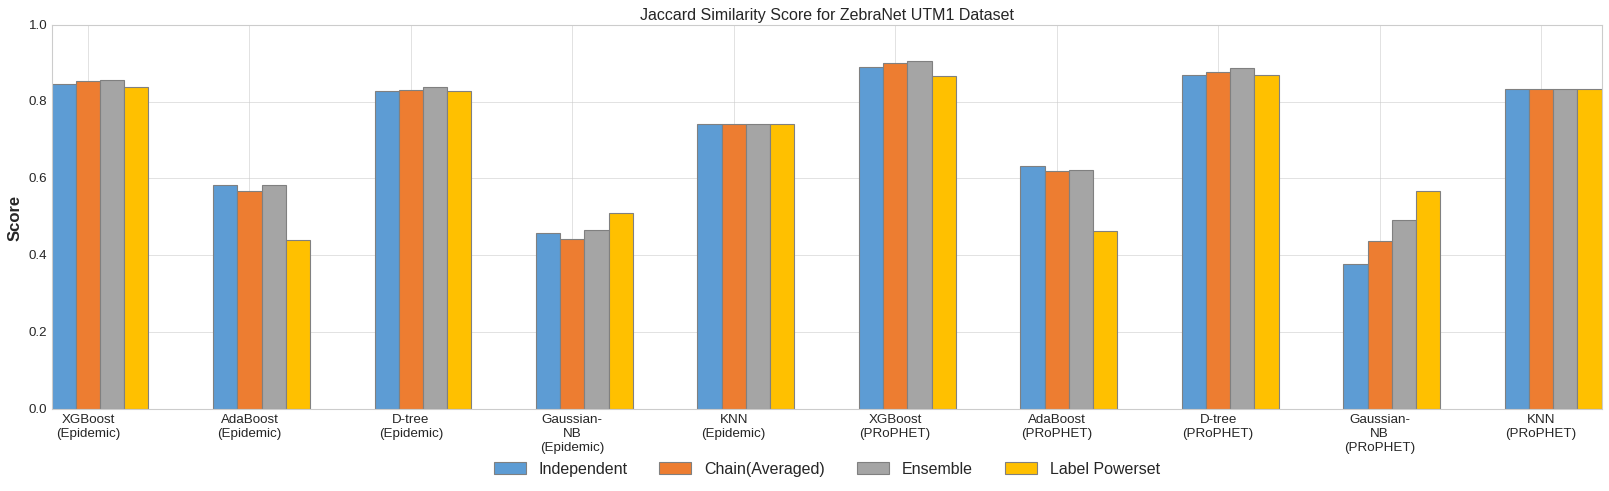

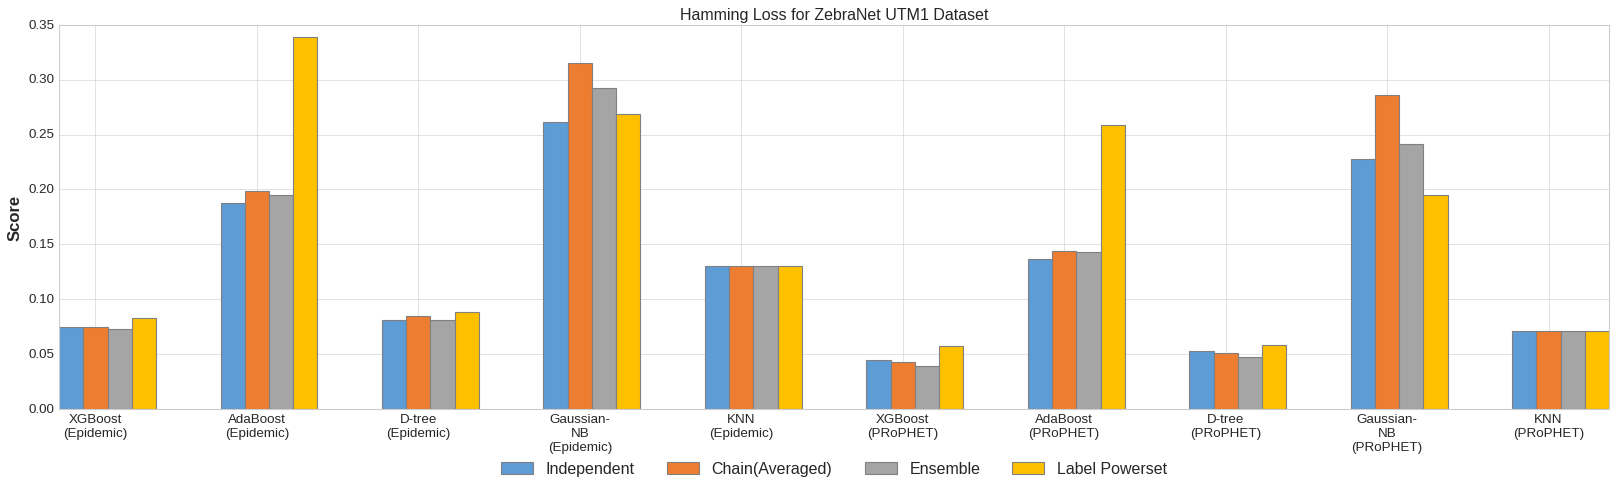

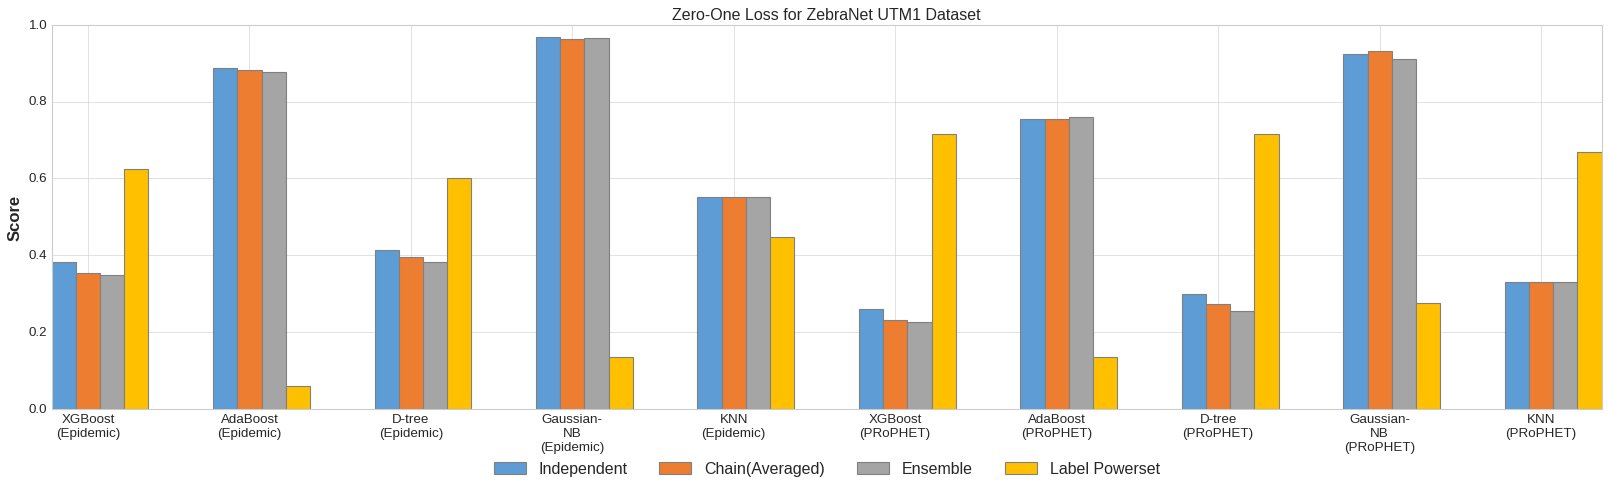

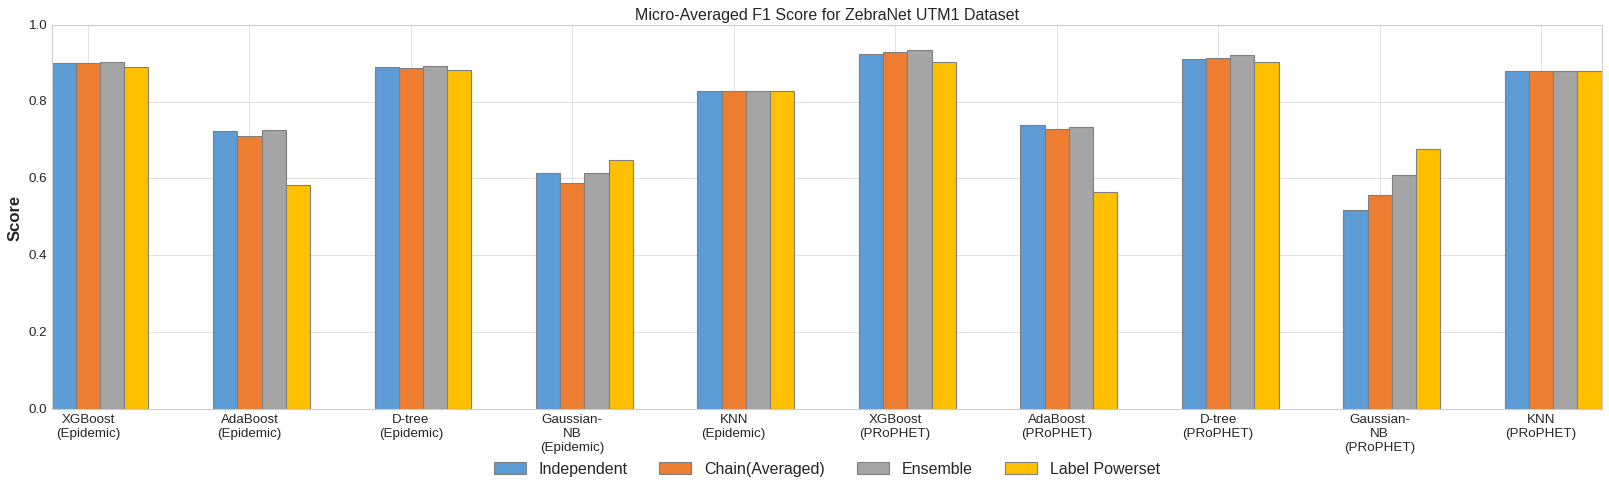

In [68]:
itr = 0
plt.style.use("seaborn-whitegrid")
for metric in metrics:
    barWidth = 0.15
    fig, ax = plt.subplots(figsize=(25, 6))
    ax.grid(True)
    ax.set_title(headers[itr])

    # Set position of bar on X axis
    br1 = np.arange(len(titles))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    plt.bar(br1,
            globals()['metric_{}_results'.format(metric)]['indep_results'],
            alpha=1,
            color='#5d9cd4',
            edgecolor='grey',
            width=barWidth,
            label='Independent')
    
    plt.bar(br2,
            globals()['metric_{}_results'.format(metric)]['chain_av_results'],
            alpha=1,
            color='#ed7d31',
            edgecolor='grey',
            width=barWidth,
            label='Chain(Averaged)')
    plt.bar(br3,
            globals()['metric_{}_results'.format(metric)]['ensemble_results'],
            alpha=1,
            color='#a5a5a5',
            edgecolor='grey',
            width=barWidth,
            label='Ensemble')
    plt.bar(br4,
            globals()['metric_{}_results'.format(metric)]['powerset_results'],
            alpha=1,
            color='#ffc000',
            edgecolor='grey',
            width=barWidth,
            label='Label Powerset')
    # Adding Xticks
    plt.ylabel('Score', fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(len(titles))], titles)
    # Adding Legend
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.1),
              fancybox=True,
              shadow=True,
              ncol=5)
    plt.plot()
    name = metric + '.jpg'
    plt.savefig(name)
    itr = itr+1

iterations = iterations + 1

In [62]:
max(metric_jaccard_results['powerset_results'])

0.8698384046759499

PRoPHET Router paired with fine-tuned XGBoost Classifier<br>
indep -> 0.890510572460031 <br>
chain-av -> 0.8993678012721333 <br>
ensemble -> 0.9063663973411267<br>
powerset -> 0.8698384046759499<br><br>

Overall Maximum Multi Label Accuracy = 90.63%
